## Tutorial on how to simulate an Argo float in Parcels

This tutorial shows how simple it is to construct a Kernel in Parcels that mimics the [vertical movement of Argo floats](http://www.argo.ucsd.edu/operation_park_profile.jpg).

In [1]:
# Define the new Kernel that mimics Argo vertical movement
def ArgoVerticalMovement(particle, fieldset, time):
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.10  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 9 * 86400  # time of deep drift in seconds

    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle.depth -= vertical_speed * particle.dt
        #particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]  # if fieldset has temperature
        if particle.depth <= fieldset.mindepth:
            particle.depth = fieldset.mindepth
            #particle.temp = 0./0.  # reset temperature to NaN at end of sampling cycle
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    particle.cycle_age += particle.dt  # update cycle_age

And then we can run Parcels with this 'custom kernel'. 

Note that below we use the two-dimensional velocity fields of GlobCurrent, as these are provided as example_data with Parcels. 

We therefore assume that the horizontal velocities are the same throughout the entire water column. However, the `ArgoVerticalMovement` kernel will work on any `FieldSet`, including from full three-dimensional hydrodynamic data. 

If the hydrodynamic data also has a Temperature Field, then uncommenting the lines about temperature will also simulate the sampling of temperature.

In [2]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
from datetime import timedelta
import numpy as np

# Load the GlobCurrent data in the Agulhas region from the example_data
filenames = {'U': "GlobCurrent_example_data/20*.nc",
             'V': "GlobCurrent_example_data/20*.nc"}
variables = {'U': 'eastward_eulerian_current_velocity',
             'V': 'northward_eulerian_current_velocity'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# Define a new Particle type including extra Variables
class ArgoParticle(JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0.)
    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
    drift_age = Variable('drift_age', dtype=np.float32, initial=0.)
    #temp = Variable('temp', dtype=np.float32, initial=np.nan)  # if fieldset has temperature

# Initiate one Argo float in the Agulhas Current
pset = ParticleSet(fieldset=fieldset, pclass=ArgoParticle, lon=[32], lat=[-31], depth=[0])

# combine Argo vertical movement kernel with built-in Advection kernel
kernels = ArgoVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
output_file = pset.ParticleFile(name="argo_float", outputdt=timedelta(minutes=30))

# Now execute the kernels for 30 days, saving data every 30 minutes
pset.execute(kernels, runtime=timedelta(days=30), dt=timedelta(minutes=5), output_file=output_file)

INFO: Compiled ArgoParticleArgoVerticalMovementAdvectionRK4 ==> /var/folders/r2/8593q8z93kd7t4j9kbb_f7p00000gr/T/parcels-504/9b8a821c179c51426159d7b7efb2e070.so
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:10 Time:  0:00:10


Now we can plot the trajectory of the Argo float with some simple calls to netCDF4 and matplotlib

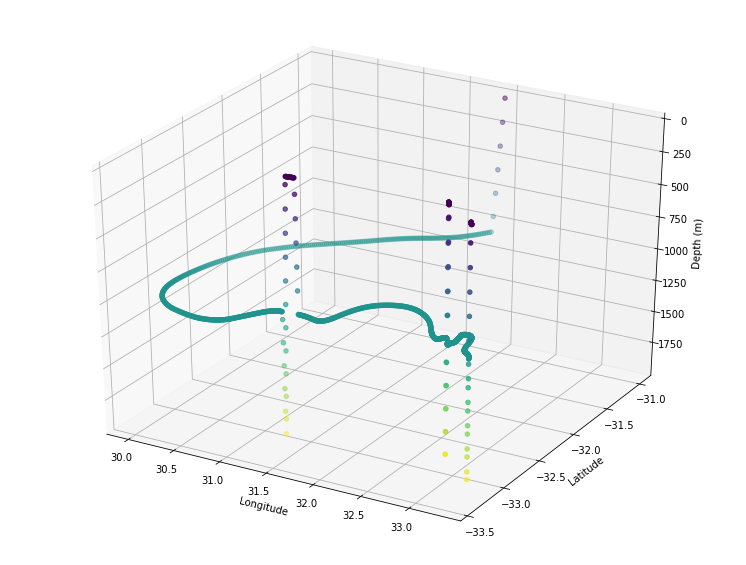

In [3]:
%matplotlib inline
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

output_file.export()  # export the trajectory data to a netcdf file

nc = netCDF4.Dataset("argo_float.nc")
x = nc.variables["lon"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
nc.close()

fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
cb = ax.scatter(x, y, z, c=z, s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z),0)
plt.show()